In [1]:
import numpy as np 
import os, json
from os.path import isdir, join
from functools import cmp_to_key
import itertools
import scipy
import scipy.stats as st
from scipy.special import gamma as gammaf

In [2]:
"""
generate score for courses and schedules based on RMP rating, # of raters, lecture time, schedule compactness...
called fixedScoreGenerator because it does not use machine learning to adjust scores. This class is used to handle the
cold-start problem 
"""
class fixedScoreGenerator:
    '''
    constructor, load in profInfoDB.json
    parameter:
        path: the path to profInforDB.json 
    return:None
    '''
    def __init__(self, path):
        with open (join(path, 'profInfoDB.json')) as handle: # read in prof info 
            self.profDB = json.load(handle)
        self.scores = np.array([score for score in self.profDB.values() if score !=[]])
        self.scores[:,0] = self.scores[:,0]/5 # normalize avg score 
        self.__fit_distribution() # fit distribution to the data (statistics tricks to generate scores)

    """
    generate score for the given course. 
    parameter:
        course: json file 
    return:
        course score
    """
    def generate_course_score(self,course):
        for session in course['session']:
            if session['instructor'] == '': # no instructor  
                score, takeAgain, numRater = 0.5, 0.5, 0.5 # chance of been liked = 0.5
            else:
                profName = session['instructor'].split(',')[1] + ' ' + session['instructor'].split(',')[0]
                try: # in case prof not found in the data base
                    profInfo = self.profDB[profName[1:]]
                    score = st.beta.cdf(profInfo[0]/5, self.scoreA, self.scoreB)
                    takeAgain = st.beta.cdf(profInfo[1], self.diffA, self.diffB)
                    numRater = st.expon.cdf(profInfo[2], self.numLoc, self.numScale)
                except:
                    score, takeAgain, numRater = 0.5, 0.5, 0.5 # confidence = 0.5
            if session['time'] == '' or session['time'] == 'TBA':
                time = 0.5 # time is not available 
            else:
                startTime = session['time'].split('-')[0] # convert start time to int
                if 'pm' in startTime and '12' not in startTime:
                    startTime = 12 + int(startTime.split(':')[0])
                else:
                    startTime = int(startTime.split(':')[0])
            
            if startTime < 9: # WHO WANTS 8AM CLASS!!
                timeScore = 0.2
            elif startTime < 12: # regular morning session
                timeScore = 0.8
            elif startTime < 14: # power nap + lunch time
                timeScore = 0.3
            elif startTime < 17: # regular afternoon class
                timeScore = 0.8
            elif startTime < 18: # dinner time
                timeScore = 0.4
            else:
                timeScore = 0.5
            sessionScore =   (1/(1+np.exp(-(numRater+2))) + 0.1) *score + 0.8*takeAgain + 0.3*timeScore
            session['score'] = sessionScore
            
    '''
    calculate how compact the schedule is by measuring the avg. std. of lecture times from Mon to Fri
    parameter:
        schedule: a list of courses json 
    return:
        schedule score
    '''      
    def generate_schedule_score(self, schedule):
        classTime = [ [] for i in range (5) ]
        for course in schedule:  # add all courses to the schedule array 
            time = course['session']['timeNumeric'] 
            if time == tuple (): # no time, skip
                continue 
            for day in time:
                avgTime =(day[0] + day[1])/2 
                classTime[int(avgTime/102)].append(avgTime%102)
        avgCourseScore = sum([course['session']['score'] for course in schedule])/len(schedule) # avg course score
        return (-0.015*sum([np.std(day) for day in classTime])/5) + avgCourseScore
    
    '''
    fit distributions to prof. rating, # of rater, difficulty level
    parameter:None
    return: None
    '''
    def __fit_distribution(self):
        # the avg score satisfies Gamma distribution 
        scoreMean, scoreVar = np.mean(self.scores[:,0]), np.var(self.scores[:,0], ddof=1) 
        self.scoreA = scoreMean**2*(1-scoreMean)/scoreVar-scoreMean
        self.scoreB = self.scoreA*(1-scoreMean)/scoreMean
        # the difficulty level is also a Gamma distribution
        diffMean, diffVar = np.mean(self.scores[:,1]), np.var(self.scores[:,1], ddof=1) 
        self.diffA = diffMean**2*(1-diffMean)/diffVar-diffMean
        self.diffB = self.diffA*(1-diffMean)/diffMean
        # num of raters fits an exponential distribution
        self.numLoc, self.numScale = st.expon.fit(self.scores[:,2])
"""
generate score for courses and schedules based on RMP rating, # of raters, lecture time, schedule compactness...
this class trains a machine learning model (naive bayes or other models that can generator probability score)

"""
        
class mlScoreGenerator:
    '''
    constructor
    parameter:
        path: the path to the training data 
    return:None
    '''
    def __init__(self, path):
        pass

    """
    generate score for the given course. 
    parameter:
        course: json file 
    return:
        course score
    """
    def generate_course_score(self,course):
        return 1
            
    '''
    calculate how compact the schedule is by measuring the avg. std. of lecture times from Mon to Fri
    parameter:
        schedule: a list of courses json 
    return:
        schedule score
    '''      
    def generate_schedule_score(self, schedule):
        return 1

In [3]:
scorer = fixedScoreGenerator('.')

In [7]:
from datetime import datetime
from collections import Counter
import copy
'''
DFS based greedy search algorithm finds the best schedules under certains contraints
for instance, if the student provides 8 courses and want at least 18 units, the algorithm 
first determines what courses are required, preferred, or just optional (priorities are provided by the user)

The scoreGenerator generates scores for each section of each course using ML/statistic, then a greedy algorithm is 
conducted to find the schedule with maximum score with no conflicts. 

How this algorithm works:
find a list of lecture layouts that satisfy contrains. Each lecture layout must contains the required courses and 
likely to have preferred courses. The order in the list is IMPORTANT as it represents the quality of lecture layouts.
Each class (lecture, lab, discussion) has a score generated by scorer that represents its quality (a mixture of RMP score,
time, difficulty level, # of raters on RMP).
For instance, there are two CSCI270 lectures, one taught by Aaron Cote, who is a great prof, and the other is taught 
by a rookie new grad. The algorithm calculates Cote's lecture first 

Then for each lecture layout the algorithm finds top 2 dicussion/lab/quiz format, now schedules are intact

Finally the algorithm evaluates the compactness of schedules and make a trade off between lecture quality and class layout. 
In other words, a compact schedule with slightly lower avg. score might end up before a scattered schedule with higher avg. score


'''
class greedySearch:
    '''
    get a list of schedules carefully selected and ranked by the greedy algorithm
    
    parameter:
    courseList: a list of interesting courses that the student want to take, a list of course json
    scorer: scorer object used to calculate class quality. Either fixed or machine-learning based 
    constrains: dictionary, contains contraints provided by users. key1: minimum unit. key2: time slot that users 
    don't want to take any class (for instance, they need to work/ can't get up at 8AM)
    Return:
        a list schedules
    
    '''
    def get_schedules(self, courseList, scorer, constrains={'unit': 17, 'avoidTime':[()]}):
        # process data generates scores for each session and sort the courseList in such a way that
        # courselist = [must have course, preferred courses, optional courses]
        # each course has {lecture: [high score, low score, full/closed lecture], dis:[high->low], lab:[], quiz:[]}
        courseList = self.__process_data(courseList, constrains, scorer)
        skeleton = []
        scheduleArray =np.array([0] *( (23-6) * 6 * 5 + 1))
        self.__DFS_greedy(courseList,'Lec', scheduleArray, skeleton,lim=30, unit=constrains['unit']) # skeleton schedules created
        # skeleton schedules(only lectures) found
        
        finalScheduleList =[[schedule] for schedule in skeleton] # a list of lists

        # find discussion, lab, quiz arrangment for each skeleton schedule
        for sessType in [('Dis',3),('Lab',3),('Quiz',1)]: # two discussion format, two lab format, 1 quiz format
            temp = [[] for i in range (len(finalScheduleList))]
            for lecLayoutIdx in range (len(finalScheduleList)): # create lab, discussion, quiz arrangements for each skeleton schedule
                for schedule in finalScheduleList[lecLayoutIdx]: # all schedules has the same lecture layout
                    choice=[]
                    scheduleArray =np.array([0] *( (23-6) * 6 * 5 + 1))
                    # filter out non-selected courses 
                    selectedCourses = set([course['name'] for course in schedule])
                    # deep copy so that we don't change selectedCourses
                    mustHave =[copy.deepcopy(course) for course in courseList if course['name'] in selectedCourses]
                    for course in mustHave:
                        course['must have'] = True # if a lecture is selected, then its discussions, lab, quiz should also be selected
                    # add selected courses to scheduleArray as contraints before start searching
                    for session in schedule:
                        self.__add_to_schedule_array(session['session'], scheduleArray)
                    # search possible schedules
                    self.__DFS_greedy(mustHave, sessType[0], scheduleArray, choice, lim = sessType[1],unit=-1)
                    for sessionList in choice: # filter out schedules without valid discussion/lab/quiz schedules 
                        temp[lecLayoutIdx].append( schedule + sessionList)
            finalScheduleList = temp # rewrite finalScheduleList because new discussion/lab/quiz is added to skeleton
        # sort schedules 
        for idx in range (len(finalScheduleList)):
            scheduleScoreList = list (map(scorer.generate_schedule_score, finalScheduleList[idx]))
            sortedList = np.argsort(scheduleScoreList)
            finalScheduleList[idx] = [finalScheduleList[idx][index] for index in sortedList] # sort schedules
        return finalScheduleList
        
    """
    dfs algorithm. Greedy as in it chooses high-score lectures first. Since the courseList is sorted, a simple DFS
    search is greedy.
    """
    def __DFS_greedy(self, courseList, sessionType, scheduleArray, scheduleList, currentChoice=[],unit = 18, lim = 20): 
        # base case 1:
        if  sum([chosen['unit'] for chosen in currentChoice]) >= unit and unit != -1:
            scheduleList.append(currentChoice[:]) # a valid schedule that satisfies unit requirement 
            return 
        # base case 2:
        elif  unit == -1 and courseList == []: # 
            scheduleList.append(currentChoice[:]) 
            return 
        elif courseList ==[]: # bottom reached but no scheduel found
            return
        course = courseList[0]
        
        # if a course does not have specific session, skip (for instance, some class does not have labs/quiz)
        if len(course['grouped'][sessionType])==0:
            self.__DFS_greedy(courseList[1:], sessionType, scheduleArray, scheduleList, currentChoice, unit, lim) 
        else:       # try each session for the given class
            for session in course['grouped'][sessionType]:
                if not self.__conflict_checker(session, scheduleArray):
                    if len(scheduleList) >= lim: # enough schedule found 
                        return 
                    self.__add_to_schedule_array(session, scheduleArray) # choose this session
                    currentChoice.append({'name': course['name'], 'unit':course['unit'], 'session':session})
                    self.__DFS_greedy(courseList[1:], sessionType, scheduleArray, scheduleList, currentChoice, unit, lim) # move to the next class
                    # remove this session so that we can try the next session 
                    self.__remove_from_schedule_array(session, scheduleArray) 
                    currentChoice.pop()
        # if a class is not a must, we can try not choosing that course (for instance, choose 5 courses out of 10)
        if not course['must have'] :
            self.__DFS_greedy(courseList[1:], sessionType, scheduleArray, scheduleList, currentChoice, unit, lim) 
            
    #--------------------------helper functions 
    '''
    calculate score for each course and sort courseList in priority order. Also removes courses that do not satisfy
    constraints. 
    parameter:
        courseList: a list of course Json
    return:
        courseList: processed courseList
    '''
        
    def __process_data(self, courseList, constrains, scoreModel):
        for course in  courseList:
            self.__time_encoder(course) #  encode session time into array index 
            scoreModel.generate_course_score(course) # generate score for each class
        courseList = sorted(courseList, key = cmp_to_key(self.__cmp_course)) #  re-arrange the course list in priority order
        for course in  courseList:
            course['session'] = sorted(course['session'], key = cmp_to_key(self.__cmp_session)) # re-arrange session lists in priority order
            tempDict ={'Lec':[], 'Lab':[], 'Dis':[], 'Quiz':[]}
            for session in course['session']:
                tempDict[session['type']].append(session)
            course['grouped'] = tempDict
        return courseList
    
    '''
    the scheduleArray is a numpy array. each index corresponds to 10 mins. 
    scheduleArray covers 6AM-11PM Mon to Fri. vacant time is marked by 0 and busy by 1
    each course is translated to index. for instance 9AM to 10AM Mon -> the course corresponds to index 18 to 24
    of the array.
    '''
    def __conflict_checker(self,session, scheduleArray):# a list of tuples
        for day in session['timeNumeric']:
            if day == tuple():
                continue
            if sum(scheduleArray[day[0]:day[1]]) >0:
                return True # conflict found
        return False # all good
    '''
    add a session to the schedule array 
    parameter: 
        session, scheduleArray
    return:
        None
    '''
    def __add_to_schedule_array(self,sess, scheduleArray):
        for day in sess['timeNumeric']:
            if day != tuple():
                scheduleArray[day[0]:day[1]] = 1
    '''
    remove a session from the schedule array 
    parameter: 
        session, scheduleArray
    return:
        None
    '''
    def __remove_from_schedule_array(self,sess, scheduleArray):
        for day in sess['timeNumeric']:
            if day != tuple():
                scheduleArray[day[0]:day[1]] = 0
        
    '''
    encode textual time into array index, which later is used to check conflicts 
    each session corresponds to chunk(s) of elements in week array
    week array contains courses from monday to friday, 6AM to 11PM with each index corresponding to 10 mins
    for instance, 8AM monday -> (8-6)=2 hours = 120 mins -> index 12. 
    This week array can help check conflicts very quickly in greedy search 
    '''
    def __time_encoder(self, course):
        for session in course['session']: 
            if session['time'] == '' or session['time'] == 'TBA':
                session['timeNumeric'] = ()
                continue
            parsed = session['time'].split(',') # get time, day of week
            days = Counter(list(parsed[1]))
            daysNumeric = [] # convert day to numbers 
            if 'M' in days:
                daysNumeric.append(0)
            if 'T' in days and ('h' not in days or days['T']>days['h']):
                daysNumeric.append(1)
            if 'W' in days:
                daysNumeric.append(2)
            if 'T' in days and 'h' in days:
                daysNumeric.append(3)
            if 'F' in days:
                daysNumeric.append (4)

            time = parsed[0].split('-') # get start, end time
            startNumeric = [int(time[0].split(':')[0]), int(time[0].split(':')[1][:2])]
            endNumeric = [int(time[1].split(':')[0]), int(time[1].split(':')[1][:2])]
            if 'pm' in time[0] and '12' not in time[0]:
                startNumeric[0] +=12
            if 'pm' in time[1] and '12' not in time[1]:
                endNumeric[0] +=12
            startNumeric = int ((startNumeric[0]-6)*6 + (startNumeric[1]/10))# convert to index
            endNumeric = int ((endNumeric[0]-6)*6 + (endNumeric[1]/10)) # convert to index
            timeNumeric = []
            for i in daysNumeric:
                timeNumeric.append(((i*102) + startNumeric, (i*102) + endNumeric))
            session['timeNumeric'] = timeNumeric
    '''
    comparison logic: must have has the ultimate priority regardless of registration status (close)
    then isFull has the secondary priority. If a session is full, it is considered last
    then prefer has the third priority. If a session is preferred but not full, it will be place behind must-have but 
    before not preferred or closed session
    parameter:
        a,b: two sessions
    return:
        1/-1: a is greater or less than b
    '''
    def __cmp_session(self, a,b):
        if a['must have'] : # if a is a must, then a has higher priority than any other session
            return -1 # a>=b
        elif b['must have']: # if b is a must, then b has higher priority than any other session
            return 1# b>a
        elif a['isFull'] and not b['isFull']: # if neither of them is a must, closed session has least priority
            return 1
        elif b['isFull'] and not a['isFull']: #
            return -1
        # neithber a nor b is a must. a and b are either both closed or both open. Consider preference
        elif a['prefer'] and not b['prefer']: # a is prefered
            return -1
        elif b['prefer'] and not a['prefer']: # b is prefered
            return 1
        else: # a and b are either both prefered or neither prefered (tie breaker)
            if a['score'] > b['score']: # session with higher score has higher priority
                return -1
            else:
                return 1
    '''
    compare two courses and determine priority
    must have > prefer > optional
    parameter:
        a,b: two courses
    return:
        1/-1/0: priority
    '''
    def __cmp_course(self, a,b):
        if a['must have']:
            return -1
        elif b['must have']:
            return 1
        elif a['prefer']:
            return -1
        elif b['prefer']:
            return 1
        else: # tie. both not prefered
            return 0 

In [14]:
model = greedySearch()
sortedL = model.get_schedules(mock, scorer, constrains={'unit': 18})

In [15]:

def duplicate_checker(schedules):
    checkedSchedule = {}
    for idx, schedule in enumerate(schedules):
        time = [course['session']['timeNumeric'] for course in schedule if course['session']['timeNumeric'] !=()] 
        flattned = []
        for course in time:
            for tuples in course:
                flattned += [tuples[0], tuples[1]]
        flattned = list(map(str,sorted (flattned)))
        key = ''.join(sorted(flattned))
        if key not in checkedSchedule:
            checkedSchedule[key] = idx
        else:
            print (idx, 'and ', checkedSchedule[key], ' are identical')
#duplicate_checker([skeleton[0] for skeleton in sortedL])
for lecLayout in sortedL:
    duplicate_checker(lecLayout)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


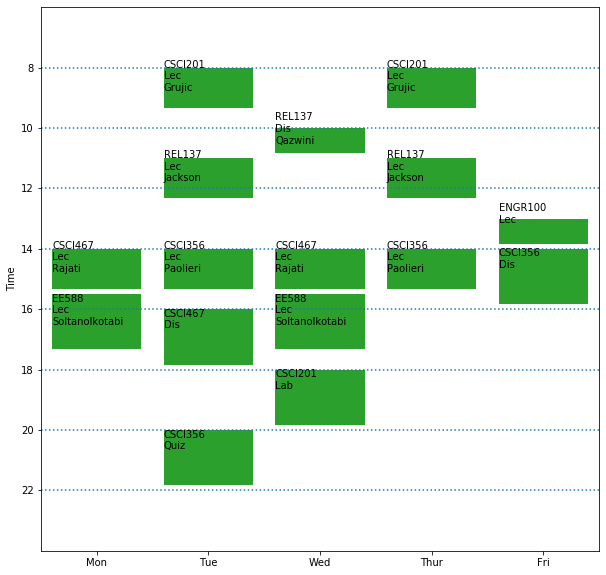

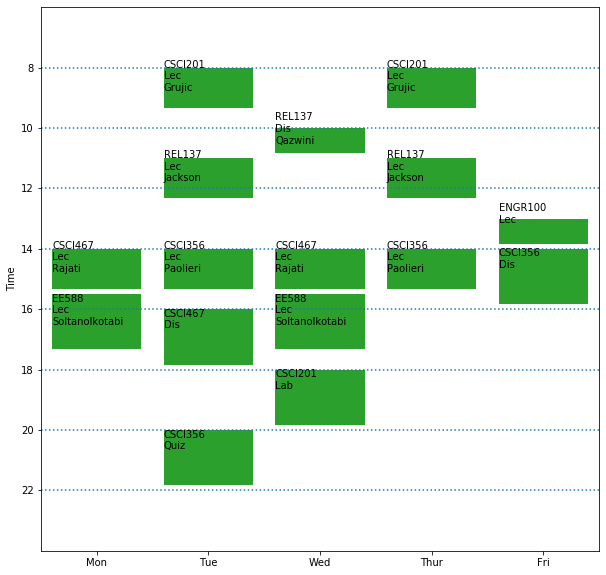

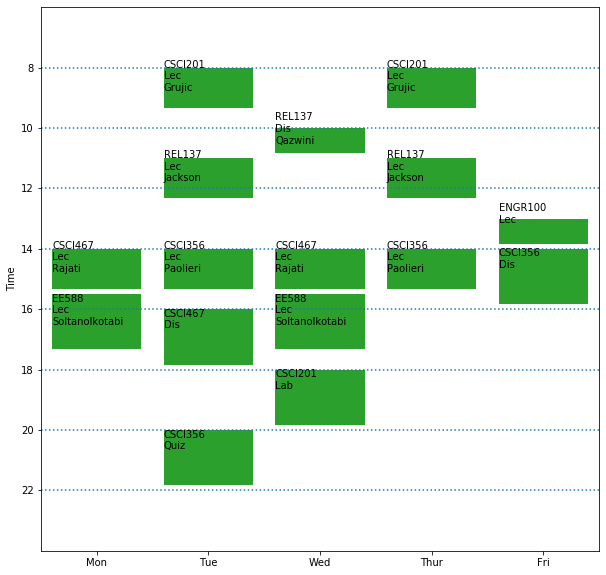

In [16]:
painter = printSchedule()
painter.show_schedule(sortedL[0][0])
painter = printSchedule()
painter.show_schedule(sortedL[0][0])
painter = printSchedule()
painter.show_schedule(sortedL[0][0])


In [12]:
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
class printSchedule:
    def __init__(self):
        self.fig, self.ax = plt.subplots() 
        self.fig.set_size_inches(10,10)
        self.ax.set_xticks([0.5,1.5,2.5,3.5,4.5])
        self.ax.set_xlim(0,5)
        self.ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri'])
        # y axis
        self.ax.set_yticks(np.arange(8,24,2))
        self.ax.set_ylim(6,24)
        self.ax.set_yticklabels(np.arange(8,24,2)[::-1])
        # set axis labels
        self.ax.set_ylabel('Time')
        # add horizontal lines 
        for i in range (8, 24, 2):
            self.ax.axhline(i, ls = ':')
    def add_course(self, course):
        # decode 
        timeList = course['session']['timeNumeric']
        name,sessType, instructor = course['name'], course['session']['type'], course['session']['instructor']
        try:
            instructor = instructor.split(',')[0]
        except:
            instructor = ''
        for period in timeList:
            start, end = period[0], period[1]
            weekday = int(start/102) + 1 # 1 -> mon, 2->Tu,...
            decoder = lambda x: -1*(int((x%102)/6)+6 + ((x%102)%6)/6) +30
            startDecoded, endDecoded = decoder(start), decoder(end)
            rect = patches.Rectangle((weekday-0.9,endDecoded),0.8,startDecoded-endDecoded,facecolor='C2')
            # Add the patch to the Axes
            self.ax.add_patch(rect)
            self.ax.text(weekday-0.9,(startDecoded + endDecoded)/2-0.1, name+ '\n'+sessType+'\n'+instructor
                         , fontsize=10)
        #self.fig.show()
    def show_schedule(self, schedule):
        for course in schedule:
            try:
                self.add_course(course)
            except:
                print (course)
        self.fig.show()

In [11]:
mock = [
{# 201 Lec
    'name': 'CSCI201',
    'must have': False,
    'prefer':False,
    'unit': 4,
    'session':
    [
        {'ID': '30303', 'type':'Lec','time':'08:00am-09:20am, TTh', 'instructor':'Grujic, Olivera', 'isFull':False ,'must have':False, 'prefer':True},
        {'ID': '30254', 'type':'Lec','time':'11:00am-12:20pm, TTh', 'instructor':'Grujic, Olivera', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '29998', 'type':'Lec','time':'12:30pm-01:50pm, TTh', 'instructor':'Grujic, Olivera', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '29979', 'type':'Lec','time':'02:00pm-03:20pm, MW' , 'instructor':'Grujic, Olivera', 'isFull':False ,'must have':False, 'prefer':False},
        {'ID': '29993', 'type':'Lec','time':'10:00am-11:50am, MW' , 'instructor':'Grujic, Olivera', 'isFull':False,'must have':False, 'prefer':False},
        # 201 discussion
        {'ID': '30239', 'type':'Lab','time':'10:00am-11:50am, W', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30238', 'type':'Lab','time':'12:00pm-01:50pm, W', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30237', 'type':'Lab','time':'02:00pm-03:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30134', 'type':'Lab','time':'04:00pm-05:50pm, T', 'instructor':'', 'isFull':True,'must have':False, 'prefer':False},
        {'ID': '30241', 'type':'Lab','time':'06:00pm-07:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '29904', 'type':'Lab','time':'06:00pm-07:50pm, W', 'instructor':'', 'isFull':True,'must have':False, 'prefer':True},
        # 201 quiz
        {'ID': '30028', 'type':'Quiz', 'time':'', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False}
    ]
},
# 356 Lec 
{
    'name': 'CSCI356',
    'must have': False,
    'prefer':False,
    'unit':4,
    'session': 
    [
        {'ID': '29962', 'type':'Lec','time':'02:00pm-03:20pm, TTh', 'instructor':'Paolieri, Marco', 'isFull':False ,'must have':False, 'prefer':False},
        {'ID': '29912', 'type':'Lec','time':'09:30am-10:50am, TTh', 'instructor':'Goodney, Andrew', 'isFull':True ,'must have':False, 'prefer':True},
        # 356 Discussino 
        {'ID': '30239', 'type':'Dis','time':'02:00pm-03:50pm, F', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30124', 'type':'Dis','time':'10:00am-11:50am, F', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        {'ID': '30239', 'type':'Dis','time':'12:00pm-01:50pm, F', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False},
        # 356 Quiz 
        {'ID': '30285', 'type':'Quiz', 'time':'08:00pm-09:50pm, T', 'instructor':'', 'isFull':False,'must have':False, 'prefer':False}
    ]
},
# 467 Lec
    
{
    'name':'CSCI467',
    'must have': False,
    'prefer': True,
    'unit':4,
    'session': 
    [
        {'ID': '30277', 'type':'Lec','time':'02:00pm-03:20pm, MW', 'instructor':'Rajati, Mohammad Reza', 'isFull':False ,'must have':False, 'prefer':False},
        # 467 Dis
        { 'ID': '30278', 'type':'Dis','time':'04:00pm-05:50pm, M', 'instructor':'', 'isFull':False ,'must have':False, 'prefer':True},
        { 'ID': '30279', 'type':'Dis','time':'04:00pm-05:50pm, T', 'instructor':'', 'isFull':False ,'must have':True, 'prefer':False}
    ]
},
# ENGR100
{
    'name':'ENGR100',
    'must have': False,
    'prefer': False,
    'unit':1,
    'session':
    [
        { 'ID': '28501', 'type':'Lec','time':'01:00pm-01:50pm, F', 'instructor':'', 'isFull':False ,'must have':False, 'prefer':False}
    ]
},
    
# REL137
{
    'name':'REL137',
    'must have': False,
    'prefer': False,
    'unit':4,
    'session':
    [
        {'ID':'60042', 'type':'Lec','time':'11:00am-12:20pm, TTh', 'instructor':'Jackson, Sherman', 'isFull': False, 'must have':False, 'prefer': False},
        
        {'ID':'60043', 'type':'Dis','time':'10:00am-10:50am, W', 'instructor':'Qazwini, Hadi', 'isFull': False, 'must have':False, 'prefer': False},
        {'ID':'60044', 'type':'Dis','time':'11:00am-11:50am, W', 'instructor':'Qazwini, Hadi', 'isFull': False, 'must have':False, 'prefer': False},
        {'ID':'60045', 'type':'Dis','time':'12:00pm-12:50pm, W', 'instructor':'Qureshi, Omar', 'isFull': False, 'must have':False, 'prefer': False},
        {'ID':'60046', 'type':'Dis','time':'01:00pm-01:50pm, W', 'instructor':'Qureshi, Omar', 'isFull': False, 'must have':False, 'prefer': False}
    ]
},
# EE588
{
    'name':'EE588',
    'must have': False,
    'prefer': True,
    'unit':4,
    'session':
    [
        {'ID':'30999', 'type':'Lec','time':'03:30pm-05:20pm, MW', 'instructor':'Soltanolkotabi, Mahdi', 'isFull': False, 'must have':False, 'prefer': False}, 
        {'ID':'31002', 'type':'Dis','time':'TBA', 'instructor':'', 'isFull': False, 'must have':False, 'prefer': False}
    ]
}
]

In [ ]:
import json
with open ('mock.json','w') as handle:
    json.dump(mock, handle)

In [ ]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(3,2)

In [ ]:
import datetime
then = datetime.datetime.now()
datetime.timedelta(days=7)
datetime.datetime.now() - then > datetime.timedelta(days=7)

In [ ]:
datetime.timedelta(days=7).seconds